In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
from IPython import display 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)
devset = Subset(devtest,randidx[:5000])
testset = Subset(devtest,randidx[5000:])

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(devset, batch_size=batchsize) # note: devtest in batches!
test_loader= DataLoader(testset, batch_size=len(testset))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
50000
5000
5000

Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def create_model():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(3,64,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)

            self.conv2 = nn.Conv2d(64,128,3)
            self.bnorm2 = nn.BatchNorm2d(128)

            self.conv3 = nn.Conv2d(128,256,3)
            self.bnorm3 = nn.BatchNorm2d(256)

            self.fc1 = nn.Linear(2*2*256,256)
            self.fc2 = nn.Linear(256,64)
            self.fc3 = nn.Linear(64,10)

        def forward(self, x):
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))

            x = F.max_pool2d(self.conv3(x),2)
            x = F.relu(self.bnorm3(x))

            nunits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nunits))

            x = F.relu(self.fc1(x))
            x = F.dropout(x,p=.5,training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x,p=.5,training=self.training)
            x = self.fc3(x)

            return x
        
    model = Model()
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.0005, weight_decay=1e-4)
    return model, loss_fun, optimizer

In [6]:
def train_model():
    EPOCHS = 50
    model, loss_fun, optimizer = create_model()
    model.to(device)

    train_loss = torch.zeros(EPOCHS)
    dev_loss = torch.zeros(EPOCHS)
    train_acc = torch.zeros(EPOCHS)
    dev_acc = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        model.train()
        batch_loss = []
        batch_acc = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss[i] = np.mean(batch_loss)
        train_acc[i] = 100 * np.mean(batch_acc)

        model.eval()
        batch_acc = []
        batch_loss = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            with torch.inference_mode():
                y_hat = model(X)
                loss = loss_fun(y_hat, y)

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item())

        dev_loss[i] = np.mean(batch_loss)
        dev_acc[i] = 100 * np.mean(batch_acc)
    
    return model, train_loss, dev_loss, train_acc, dev_acc


In [7]:
model, train_loss, dev_loss, train_acc, dev_acc = train_model()

In [8]:
## the real test set!

model.eval() # switch to test mode
loss_fun = nn.CrossEntropyLoss()
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = model(X)
  loss = loss_fun(yHat,y)

# loss and accuracy from this batch
test_loss = loss.item()
test_acc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

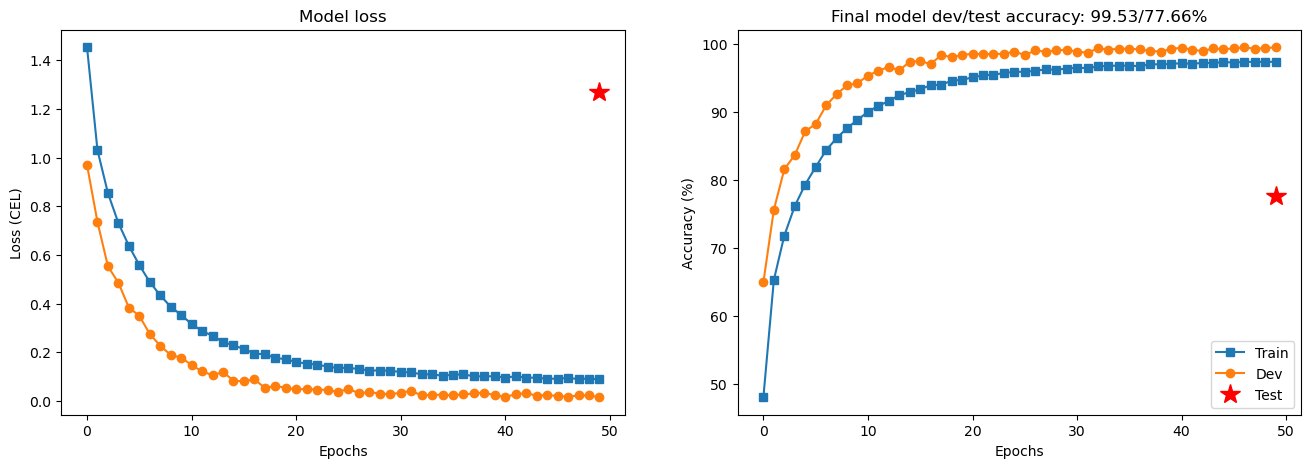

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(dev_loss,'o-',label='Dev')
ax[0].plot(len(dev_loss)-1,test_loss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(dev_acc,'o-',label='Dev')
ax[1].plot(len(dev_acc)-1,test_acc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {dev_acc[-1]:.2f}/{test_acc:.2f}%')
ax[1].legend()

plt.show()